<a href="https://colab.research.google.com/github/pt2y1003/surveyed_papers/blob/main/Bootstrap_vs_DeLong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

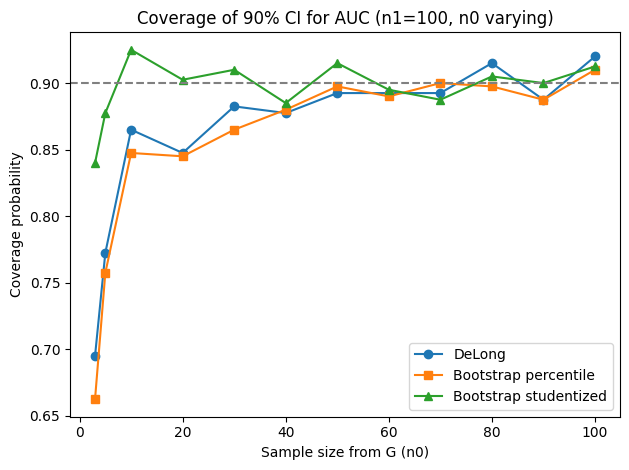

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import erf, sqrt

# RNG
rng = np.random.default_rng(12345)

# Parameters
n1 = 100  # sample size from F
n0_list = [3,5,10,20,30,40,50,60,70,80,90,100]
alpha = 0.10
n_rep = 400   # Monte Carlo repetitions
B = 200       # bootstrap reps

# True AUC target 0.75
z_target = 0.67448975  # Phi^{-1}(0.75)
d = z_target * sqrt(2.0)
mu1 = d
mu0 = 0.0

def normal_cdf(x):
    return 0.5 * (1.0 + erf(x / np.sqrt(2.0)))

true_auc = normal_cdf((mu1 - mu0) / np.sqrt(2.0))

def delong_auc_var(pos, neg):
    pos = np.asarray(pos)
    neg = np.asarray(neg)
    m = len(pos)
    n = len(neg)
    diff = pos[:, None] - neg[None, :]
    v = (diff > 0).astype(float) + 0.5 * (diff == 0).astype(float)
    v10 = v.mean(axis=1)
    v01 = v.mean(axis=0)
    auc = v10.mean()
    s10 = np.var(v10, ddof=1) if m > 1 else 0.0
    s01 = np.var(v01, ddof=1) if n > 1 else 0.0
    var = s10 / m + s01 / n
    return auc, var

def bootstrap_cis(pos, neg, B, alpha):
    pos = np.asarray(pos)
    neg = np.asarray(neg)
    m = len(pos)
    n = len(neg)

    auc_hat, var_hat = delong_auc_var(pos, neg)
    se_hat = np.sqrt(max(var_hat, 1e-12))

    auc_bs = np.empty(B)
    t_bs = np.empty(B)

    for b in range(B):
        idx_pos = rng.integers(0, m, size=m)
        idx_neg = rng.integers(0, n, size=n)
        pos_b = pos[idx_pos]
        neg_b = neg[idx_neg]
        auc_b, var_b = delong_auc_var(pos_b, neg_b)
        se_b = np.sqrt(max(var_b, 1e-12))
        auc_bs[b] = auc_b
        t_bs[b] = (auc_b - auc_hat) / se_b

    # Percentile CI
    lower_pct = np.quantile(auc_bs, alpha/2.0)
    upper_pct = np.quantile(auc_bs, 1.0 - alpha/2.0)

    # Studentized CI
    t_low = np.quantile(t_bs, 1.0 - alpha/2.0)
    t_high = np.quantile(t_bs, alpha/2.0)
    lower_stud = auc_hat - t_low * se_hat
    upper_stud = auc_hat - t_high * se_hat

    return auc_hat, (lower_pct, upper_pct), (lower_stud, upper_stud)

# Coverage results
coverage_delong = []
coverage_boot_pct = []
coverage_boot_stud = []

z_90 = 1.6448536269514722  # 90% two-sided

for n0 in n0_list:
    cover_d = cover_p = cover_s = 0

    for _ in range(n_rep):
        pos = rng.normal(loc=mu1, scale=1.0, size=n1)
        neg = rng.normal(loc=mu0, scale=1.0, size=n0)

        # DeLong CI
        auc_hat, var_hat = delong_auc_var(pos, neg)
        se_hat = np.sqrt(max(var_hat, 1e-12))
        ci_d = (auc_hat - z_90 * se_hat, auc_hat + z_90 * se_hat)

        # Bootstraps
        _, ci_pct, ci_stud = bootstrap_cis(pos, neg, B=B, alpha=alpha)

        # Coverage check
        if ci_d[0] <= true_auc <= ci_d[1]:
            cover_d += 1
        if ci_pct[0] <= true_auc <= ci_pct[1]:
            cover_p += 1
        if ci_stud[0] <= true_auc <= ci_stud[1]:
            cover_s += 1

    coverage_delong.append(cover_d / n_rep)
    coverage_boot_pct.append(cover_p / n_rep)
    coverage_boot_stud.append(cover_s / n_rep)

# Plot
plt.figure()
plt.plot(n0_list, coverage_delong, marker='o', label='DeLong')
plt.plot(n0_list, coverage_boot_pct, marker='s', label='Bootstrap percentile')
plt.plot(n0_list, coverage_boot_stud, marker='^', label='Bootstrap studentized')
plt.axhline(0.9, linestyle='--', color='gray')
plt.xlabel('Sample size from G (n0)')
plt.ylabel('Coverage probability')
plt.title('Coverage of 90% CI for AUC (n1=100, n0 varying)')
plt.legend()
plt.tight_layout()
plt.show()
